# Imports

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
%matplotlib inline
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
import sys, os
from collections import Counter
import itertools
from itertools import compress
import operator
import pickle
from sklearn.metrics import accuracy_score, matthews_corrcoef, mean_squared_error
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split

Mounted at /content/drive


In [ ]:
!pip install torch-geometric \
  torch-sparse==latest+cu102 \
  torch-scatter==latest+cu102 \
  torch-cluster==latest+cu102 \
  torch-spline-conv==latest+cu102 \
  -f https://pytorch-geometric.com/whl/torch-1.7.0.html

from torch_geometric.nn import TopKPooling, GraphConv
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
import torch.nn.functional as F

#!pip install --upgrade -i https://test.pypi.org/pypi/ glycowork
from ./glycowork.py import *

!pip install torch==1.7.0
import torch

# File Imports
- imports glycan sequences with taxonomic information and glycan graph features
- constructs a library of observed glycoletters (unique monosaccharides + linkages)

In [ ]:
taxonomic_glycans = pd.read_csv('data/glyco_targets_species_seq_all_V3.csv')
graph_df = pd.read_csv('data/train_graph_full.csv')
comb = pd.concat([graph_df, taxonomic_glycans], axis = 1)

lib = get_lib(taxonomic_glycans.target.values.tolist())
lib_size = len(lib)

# Data Preprocessing
- generates training / test set for training a taxonomic classifier based on SweetNet
- you can change rank to other taxonomic level

In [ ]:
train_x, val_x, train_y, val_y, id_val, class_list, class_converter = hierarchy_filter(taxonomic_glycans,
                                                                                       rank = 'kingdom')

glycan_graphs_train = dataset_to_graphs(train_x, train_y, libr = lib)
glycan_graphs_val = dataset_to_graphs(val_x, val_y, libr = lib)

train_loader = DataLoader(glycan_graphs_train, batch_size = 32, shuffle = True)
val_loader = DataLoader(glycan_graphs_val, batch_size = 32, shuffle = False)
dataloaders = {'train':train_loader, 'val':val_loader}

# Model Definition + Training Loop
- defines SweetNet, the EarlyStopping function, and the training function

In [ ]:
class SweetNet(torch.nn.Module):
    def __init__(self, num_classes = 1):
        super(SweetNet, self).__init__() 

        self.conv1 = GraphConv(128, 128)
        self.pool1 = TopKPooling(128, ratio = 0.8)
        self.conv2 = GraphConv(128, 128)
        self.pool2 = TopKPooling(128, ratio = 0.8)
        self.conv3 = GraphConv(128, 128)
        self.pool3 = TopKPooling(128, ratio = 0.8)
        self.item_embedding = torch.nn.Embedding(num_embeddings = lib_size+1, embedding_dim = 128)
        self.lin1 = torch.nn.Linear(256, 1024)
        self.lin2 = torch.nn.Linear(1024, 64)
        self.lin3 = torch.nn.Linear(64, num_classes)
        self.bn1 = torch.nn.BatchNorm1d(1024)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.act1 = torch.nn.LeakyReLU()
        self.act2 = torch.nn.LeakyReLU()      
  
    def forward(self, x, edge_index, batch, inference = False):
        att = 0
        x = self.item_embedding(x)
        x = x.squeeze(1) 

        x = F.leaky_relu(self.conv1(x, edge_index))

        x, edge_index, _, batch, _, _= self.pool1(x, edge_index, None, batch)
        x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim = 1)

        x = F.leaky_relu(self.conv2(x, edge_index))
     
        x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
        x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim = 1)

        x = F.leaky_relu(self.conv3(x, edge_index))

        x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
        x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim = 1)

        x = x1 + x2 + x3
        
        x = self.lin1(x)
        x = self.bn1(self.act1(x))
        x = self.lin2(x)
        x = self.bn2(self.act2(x))      
        x = F.dropout(x, p = 0.5, training = self.training)

        x = self.lin3(x).squeeze(1)

        if inference:
          x_out = x1 + x2 + x3
          return x, x_out, att
        else:
          return x

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience = 7, verbose = False):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = 0

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        self.val_loss_min = val_loss

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 100.0
  best_acc = 0
  val_losses = []
  val_acc = []
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*10)
    
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
        
      running_loss = []
      running_acc = []
      running_mcc = []
      for data in dataloaders[phase]:
        x, y, edge_index, batch = data.x, data.y, data.edge_index, data.batch
        x = x.cuda()
        y = y.cuda()
        edge_index = edge_index.cuda()
        batch = batch.cuda()
        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          pred = model(x, edge_index, batch)
          loss = criterion(pred, y)

          if phase == 'train':
            loss.backward()
            optimizer.step()
            
        running_loss.append(loss.item())
        pred2 = np.argmax(pred.cpu().detach().numpy(), axis = 1)
        running_acc.append(accuracy_score(
                                   y.cpu().detach().numpy().astype(int), pred2))
        running_mcc.append(matthews_corrcoef(y.detach().cpu().numpy(), pred2))
        
      epoch_loss = np.mean(running_loss)
      epoch_acc = np.mean(running_acc)
      epoch_mcc = np.mean(running_mcc)
      print('{} Loss: {:.4f} Accuracy: {:.4f} MCC: {:.4f}'.format(
          phase, epoch_loss, epoch_acc, epoch_mcc))
      
      if phase == 'val' and epoch_loss <= best_loss:
        best_loss = epoch_loss
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
      if phase == 'val':
        val_losses.append(epoch_loss)
        val_acc.append(epoch_acc)
        early_stopping(epoch_loss, model)

      scheduler.step()
        
    if early_stopping.early_stop:
      print("Early stopping")
      break
    print()
    
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val loss: {:4f}, best Accuracy score: {:.4f}'.format(best_loss, best_acc))
  model.load_state_dict(best_model_wts)

  ## plot loss & accuracy score over the course of training 
  fig, ax = plt.subplots(nrows = 2, ncols = 1) 
  plt.subplot(2, 1, 1)
  plt.plot(range(epoch+1), val_losses)
  plt.title('Training of SweetNet')
  plt.ylabel('Validation Loss')
  plt.legend(['Validation Loss'],loc = 'best')

  plt.subplot(2, 1, 2)
  plt.plot(range(epoch+1), val_acc)
  plt.ylabel('Validation Accuracy')
  plt.xlabel('Number of Epochs')
  plt.legend(['Validation Accuracy'], loc = 'best')
  return model

# Model Training
- instantiating the model and training it to completion
- uncomment train_model if you want to train a new model

In [ ]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.sparse_(m.weight, sparsity = 0.1)

model = SweetNet(num_classes = len(class_list))
model.apply(init_weights)
model.cuda()

early_stopping = EarlyStopping(patience = 50, verbose = True)
optimizer_ft = torch.optim.Adam(model.parameters(), lr = 0.0005, weight_decay = 0.001)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, 50)
criterion = torch.nn.CrossEntropyLoss().cuda()
#model_ft = train_model(model, criterion, optimizer_ft, scheduler,
#                   num_epochs = 100)

# Extracting Glycan Representations
- loads trained model and hands it all glycan sequences as input to get predictions and representations

In [ ]:
model_ft = SweetNet(num_classes = len(class_list))
model_ft.load_state_dict(torch.load('models/sweetnet_kingdom.pt'))
model_ft = model_ft.cuda()

In [ ]:
abc = list(range(len(taxonomic_glycans.species.values.tolist())))
glycan_graphs = dataset_to_graphs(taxonomic_glycans.target.values.tolist(), abc, libr = lib)
glycan_loader = DataLoader(glycan_graphs, batch_size = 32, shuffle = False)

res = []
for data in glycan_loader:
  x, y, edge_index, batch = data.x, data.y, data.edge_index, data.batch
  x = x.cuda()
  y = y.cuda()
  edge_index = edge_index.cuda()
  batch = batch.cuda()
  model_ft = model_ft.eval()
  pred, out, _ = model_ft(x, edge_index, batch, inference = True)
  res.append(out)
  #uncomment for getting actual predictions
  #res.append(pred)

res2 = [res[k].detach().cpu().numpy() for k in range(len(res))]
res2 = pd.DataFrame(np.concatenate(res2))

In [ ]:
#t-SNE dimensionality reduction for plotting
tsne_emb = TSNE(random_state = 42).fit_transform(res2)

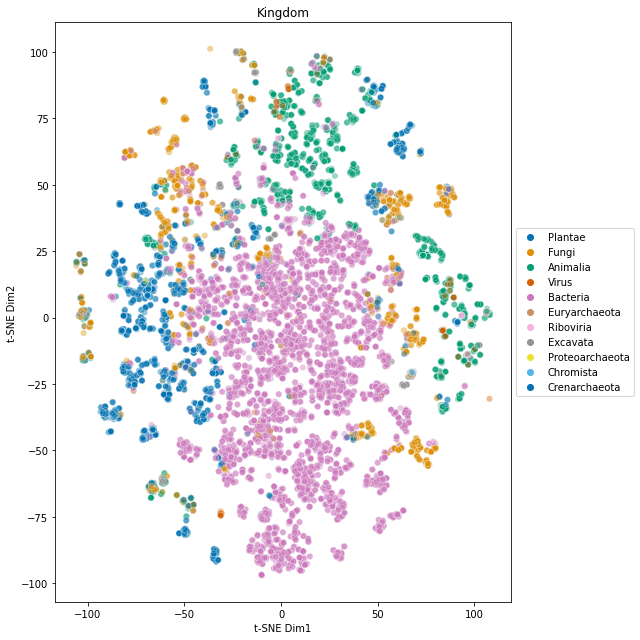

In [ ]:
plt.figure(figsize = (9, 9))
sns.scatterplot(x = tsne_emb[:,0], y = tsne_emb[:,1], s = 40, alpha = 0.4,
                hue = taxonomic_glycans.kingdom.values.tolist(), palette = 'colorblind', rasterized = True)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.xlabel('t-SNE Dim1')
plt.ylabel('t-SNE Dim2')
plt.title('Kingdom')
plt.tight_layout()

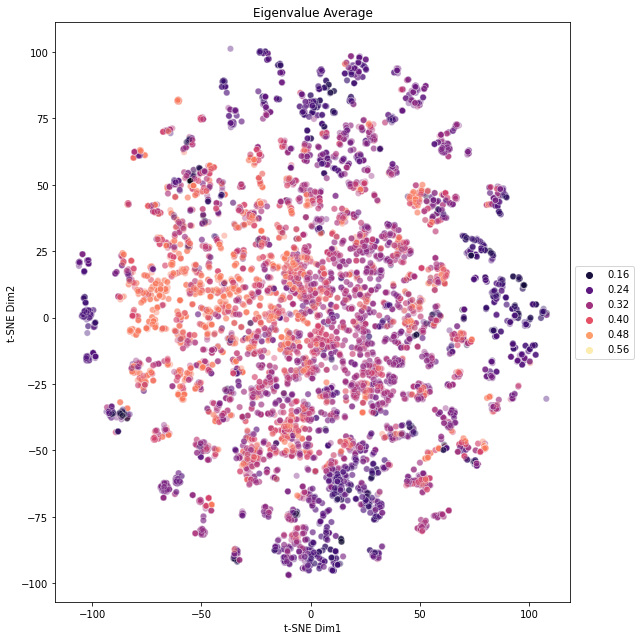

In [ ]:
plt.figure(figsize = (9, 9))
sns.scatterplot(x = tsne_emb[:,0], y = tsne_emb[:,1], s = 40, alpha = 0.4,
                hue = graph_df.eigenAvg.values.tolist(), palette = 'magma', rasterized = True)
plt.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
plt.xlabel('t-SNE Dim1')
plt.ylabel('t-SNE Dim2')
plt.title('Eigenvalue Average')
plt.tight_layout()

# Predicting Viral-Glycan Binding
- includes code to load relevant data, process it, and train models predicting viral-glycan binding

In [ ]:
#converts glycans into standardized nomenclature
recode_df = pd.read_csv('data/glycan_recoding_master.csv', encoding = 'latin-1')
#dataset of virus/glycan interactions, NaN means this specific virus/glycan pair was not tested
df = pd.read_csv('data/array_results.csv')
#meta information about viruses used for screening; some viruses lack some information (e.g., sequence or full strain name)
viral_meta = pd.read_csv('data/viral_meta.csv')

#glycan binding typically 130loop/150loop/190helix/220loop
viral_meta['core_seq'] = [k[50:300] if len(str(k)) > 200 else k if ~pd.isnull(k) else np.nan for k in viral_meta.sequence.values.tolist()]

def densify_database(df, recode_df = recode_df):
  """combines columns describing the same glycan with different nomenclatures"""
  target = df.target.values.tolist()
  recode_df = pd.Series(recode_df.cleaned.values, index = recode_df.original).to_dict()
  df.columns = [recode_df[re.sub(r'[^a-zA-Z0-9.\-\_\'\*\,\+\)\(\[\]/]', r'', k).split('.')[0]] for k in df.columns.values.tolist()]
  df = df.groupby(by = df.columns, axis = 1).apply(lambda x: x.mean(axis = 1))
  df.target = target
  return df

df = densify_database(df)
complete = viral_meta.virus_id[viral_meta.sequence.notnull()].values.tolist()
print(df.shape)
df = df[df.target.isin(complete)]
print(df.shape)

(701, 826)
(587, 826)


In [ ]:
def normalize_arrays(train_in, train_test = False, val = None, normalize = False):
  """for now, normalizes by Z-scores if normalize = True"""
  train = copy.deepcopy(train_in)
  target = train.target.values.tolist()
  train.drop(['target'], axis = 1, inplace = True)
  if train_test:
    target2 = val.target.values.tolist()
    val.drop(['target'], axis = 1, inplace = True)
    sample2 = val.div(val.mean(axis = 1), axis = 0)
    condition2 = val.div(train.mean(axis = 0), axis = 1)
    val = sample2*condition2
    val['target'] = target2
  sample = train.div(train.mean(axis = 1), axis = 0)
  condition = train.div(train.mean(axis = 0), axis = 1)
  train = sample*condition
  if normalize:
    df = train_in.drop(['target'], axis = 1).T
    for col in range(len(df.columns.values.tolist())):
      df.iloc[:,col] = (df.iloc[:,col] - df.iloc[:,col].mean())/df.iloc[:,col].std(ddof = 0)
    train = df.T
  train['target'] = target
  return train, val

#normalize data by Z-score transformation
df.target = [viral_meta[viral_meta.virus_id == k]['sequence'].values.tolist()[0] for k in df.target.values.tolist()]
df = df[df.target.notnull()].reset_index(drop = True)
df.target = [k.upper() for k in df.target.values.tolist()]
train, _ = normalize_arrays(df, train_test = False, normalize = True)

In [ ]:
#reformat glycan column names and merge duplicate columns by averaging
train = train.groupby(by = 'target').mean().reset_index()
temp = train.pop('target')
train = train[train.columns[train.columns.to_series().str.contains('\(')]]
train.columns = ['-'.join(k.split('-')[:-1]) for k in train.columns.values.tolist()]
train = train.groupby(by = train.columns, axis = 1).apply(lambda g: g.mean(axis = 1))
train['target'] = temp

def generate_pair_data(df):
  """creates 3-tuples of virus, glycan, and the corresponding binding value"""
  out = []
  for k in range(len(df)):
    for j in range(df.shape[1]-1):
      if ~np.isnan(df.iloc[k,j]) and np.isfinite(df.iloc[k,j]):
        out.append((df.loc[k,'target'], df.columns.values.tolist()[j], df.iloc[k,j]))
  return out

train = generate_pair_data(train)

In [ ]:
#make training dataframe and label-encode protein sequence
train2 = pd.DataFrame(train, columns = ['seq_window_aa', 'glycan', 'match'])
max_len = np.max([len(k) for k in train2.seq_window_aa.values.tolist()])
chars = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T',
     'V','W','Y', 'X']
train2.seq_window_aa = [pad_sequence(string_to_labels(k, libr = chars), max_length = max_len) for k in train2.seq_window_aa.values.tolist()]

In [ ]:
#construct library of observed glycoletters (monosaccharides/linkages) in dataset
lib = get_lib(train2.glycan.values.tolist())
lib_size = len(lib)

#data max / min for sigmoid in the model
data_max = np.max(train2.match.values.tolist())
data_min = np.min(train2.match.values.tolist())

In [ ]:
#split into training and test data
X_train, X_val, y_train, y_val = train_test_split(list(zip(train2.seq_window_aa.values.tolist(),
                                                           dataset_to_graphs(train2.glycan.values.tolist(), list(range(len(train2))), libr = lib, wo_labels = True))),
                                                  train2.match.values.tolist(), test_size = 0.2, random_state = 42)

In [ ]:
#generate dataloaders for training the model
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self, df, labs):
    self.df = df
    self.labs = labs
    self.max_len = len(max(self.df, key = len))
    self.idx = range(len(self.df)) 
    
  def __len__(self):
    return len(self.idx)
  
  def __getitem__(self,index):
    index = self.idx[index]
    prot = self.df[index][0]
    glyco = self.df[index][1]
    labels = self.labs[index]
    return (torch.LongTensor(prot), torch.FloatTensor([labels]), [index])

trainset = CustomDataset(X_train, y_train)
trainset_loader = torch.utils.data.DataLoader(trainset, batch_size = 32,
                               shuffle = True, num_workers = 4)
valset = CustomDataset(X_val, y_val)
valset_loader = torch.utils.data.DataLoader(valset, batch_size = 32,
                              shuffle = False, num_workers = 4)

trainset_g = [X_train[k][1] for k in range(len(X_train))]
trainset_loader_g = DataLoader(trainset_g, batch_size = 32,
                            shuffle=True, num_workers = 4) 
valset_g = [X_val[k][1] for k in range(len(X_val))]
valset_loader_g = DataLoader(valset_g, batch_size = 32, shuffle = False,
                             num_workers = 4)

dataloaders = {'train':trainset_loader, 'val':valset_loader}
dataloaders_g = {'train':trainset_g, 'val':valset_g}

In [ ]:
#model definition
def sigmoid_range(x, low, high):
    "Sigmoid function with range `(low, high)`"
    return torch.sigmoid(x) * (high - low) + low

class SigmoidRange(torch.nn.Module):
    "Sigmoid module with range `(low, x_max)`"
    def __init__(self, low, high):
      super(SigmoidRange, self).__init__()
      self.low, self.high = low,high
    def forward(self, x): return sigmoid_range(x, self.low, self.high)

class RNN_graph(torch.nn.Module):
  def __init__(self, input_size_prot, input_size_glyco, hidden_size, num_classes, data_min,
               data_max, n_layers = 1):
    super(RNN_graph,self).__init__()
    self.input_size_prot = input_size_prot
    self.input_size_glyco = input_size_glyco
    self.hidden_size = hidden_size
    self.num_classes = num_classes
    self.n_layers = n_layers
    
    self.conv1 = GraphConv(128, 128)
    self.pool1 = TopKPooling(128, ratio = 0.8)
    self.conv2 = GraphConv(128, 128)
    self.pool2 = TopKPooling(128, ratio = 0.8)
    self.conv3 = GraphConv(128, 128)
    self.pool3 = TopKPooling(128, ratio = 0.8)
    self.item_embedding = torch.nn.Embedding(num_embeddings = lib_size+1, embedding_dim = 128)
    self.prot_encoder = torch.nn.Embedding(input_size_prot, hidden_size, padding_idx = len(chars))
    self.glyco_encoder = torch.nn.Embedding(input_size_glyco, hidden_size, padding_idx = lib_size)
    self.lstm_prot = torch.nn.LSTM(hidden_size, hidden_size, n_layers, bidirectional = False)
    self.dp0 = torch.nn.Dropout(0.2)
    self.dp1 = torch.nn.Dropout(0.5)
    self.fc1 = torch.nn.Linear(hidden_size+256, int(np.round(hidden_size/2)))
    self.fc2 = torch.nn.Linear(int(np.round(hidden_size/2)), num_classes)
    self.bn1 = torch.nn.BatchNorm1d(int(np.round(hidden_size/2)))
    self.act1 = torch.nn.LeakyReLU()
    self.act2 = torch.nn.LeakyReLU()
    self.sigmoid = SigmoidRange(data_min, data_max)
    
    
  def forward(self, prot, nodes, edge_index, batch, hidden = None, inference = False):
    embedded_prot = self.prot_encoder(prot)
    embedded_prot = embedded_prot.transpose(0,1)
    outputs_prot, (h_n_prot, c_n_prot) = self.lstm_prot(embedded_prot, hidden)

    h_n_prot = h_n_prot.squeeze(0)

    x = self.item_embedding(nodes)
    x = x.squeeze(1) 

    x = F.leaky_relu(self.conv1(x, edge_index))

    x, edge_index, _, batch, _, _= self.pool1(x, edge_index, None, batch)
    x1 = torch.cat([gmp(x, batch), gap(x, batch)], dim = 1)

    x = F.leaky_relu(self.conv2(x, edge_index))
     
    x, edge_index, _, batch, _, _ = self.pool2(x, edge_index, None, batch)
    x2 = torch.cat([gmp(x, batch), gap(x, batch)], dim = 1)

    x = F.leaky_relu(self.conv3(x, edge_index))
        
    x, edge_index, _, batch, _, _ = self.pool3(x, edge_index, None, batch)
    x3 = torch.cat([gmp(x, batch), gap(x, batch)], dim = 1)

    x = x1 + x2 + x3

    h_n = torch.cat((h_n_prot, x), 1)
    
    h_n = self.bn1(self.act1(self.fc1(h_n)))

    x1 = self.fc2(self.dp1(h_n))
    x2 = self.fc2(self.dp1(h_n))
    x3 = self.fc2(self.dp1(h_n))
    x4 = self.fc2(self.dp1(h_n))
    x5 = self.fc2(self.dp1(h_n))
    x6 = self.fc2(self.dp1(h_n))
    x7 = self.fc2(self.dp1(h_n))
    x8 = self.fc2(self.dp1(h_n))
    
    out =  self.sigmoid(torch.mean(torch.stack([x1, x2, x3, x4, x5, x6, x7, x8]), dim = 0))
    
    if inference:
      return out, hidden, h_n
    else:
      return out, hidden

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
  """training loop for virus-glycan binding model"""
  since = time.time()
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 100.0
  val_losses = []
  val_acc = []
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-'*10)
    
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
        
      running_loss = []
      running_acc = []
      for batch in dataloaders[phase]:
        prot,  outputs, prot_env, idx = batch
        idx = idx[0].numpy().tolist()
        batch_g = [dataloaders_g[phase][k] for k in idx]
        temp = DataLoader(batch_g, batch_size = len(batch_g))
        batch_g = next(iter(temp))
        nodes, edges, batch = batch_g.x, batch_g.edge_index, batch_g.batch
        prot = prot.cuda()
        nodes = nodes.cuda()
        edges = edges.cuda()
        batch = batch.cuda()
        prot_env = prot_env.cuda()
        outputs = outputs.cuda()
        optimizer.zero_grad()
        
        with torch.set_grad_enabled(phase == 'train'):
          pred,_ = model(prot, nodes, edges, batch, prot_env)
          pred_acc = (pred>=0.5)*1
          loss = criterion(pred, outputs)
          if phase == 'train':
            loss.backward()
            optimizer.step()
            
        running_loss.append(loss.item())
        running_acc.append(mean_squared_error(outputs.detach().cpu().numpy(), pred.detach().cpu().numpy()))
        
      epoch_loss = np.mean(running_loss)
      epoch_acc = np.mean(running_acc)
      print('{} Loss: {:.4f} MSE: {:.4f}'.format(
          phase, epoch_loss, epoch_acc))
      
      if phase == 'val' and epoch_acc <= best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
      if phase == 'val':
        val_losses.append(epoch_loss)
        val_acc.append(epoch_acc)
        early_stopping(epoch_loss, model)

      scheduler.step()
        
    if early_stopping.early_stop:
      print("Early stopping")
      break
    print()
    
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
      time_elapsed // 60, time_elapsed % 60))
  print('Best val MSE: {:4f}'.format(best_acc))
  model.load_state_dict(best_model_wts)

  ## plot loss & MSE over the course of training 
  fig, ax = plt.subplots(nrows = 2, ncols = 1) 
  plt.subplot(2, 1, 1)
  plt.plot(range(epoch+1), val_losses)
  plt.title('Training of Model')
  plt.ylabel('Validation Loss')
  plt.legend(['Validation Loss'], loc = 'best')

  plt.subplot(2, 1, 2)
  plt.plot(range(epoch+1), val_acc)
  plt.ylabel('Validation MSE')
  plt.xlabel('Number of Epochs')
  plt.legend(['Validation MSE'], loc = 'best')
  return model

In [ ]:
#actually training the model
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.sparse_(m.weight, sparsity = 0.1)

## instantiating the RNN itself, initializing it and putting it on the GPU             
rnn = RNN_graph(input_size_prot = len(chars)+1, input_size_glyco = lib_size+1, hidden_size = 128,
          num_classes = 1, data_min = data_min, data_max = data_max)
rnn.apply(init_weights)
rnn.cuda()

early_stopping = EarlyStopping(patience = 20, verbose = True)
optimizer_ft = torch.optim.Adam(rnn.parameters(), lr = 0.0003, weight_decay = 0.)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, 170)
criterion = torch.nn.MSELoss().cuda()
model_ft = train_model(rnn, criterion, optimizer_ft, scheduler,
                    num_epochs = 250)